In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn 


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


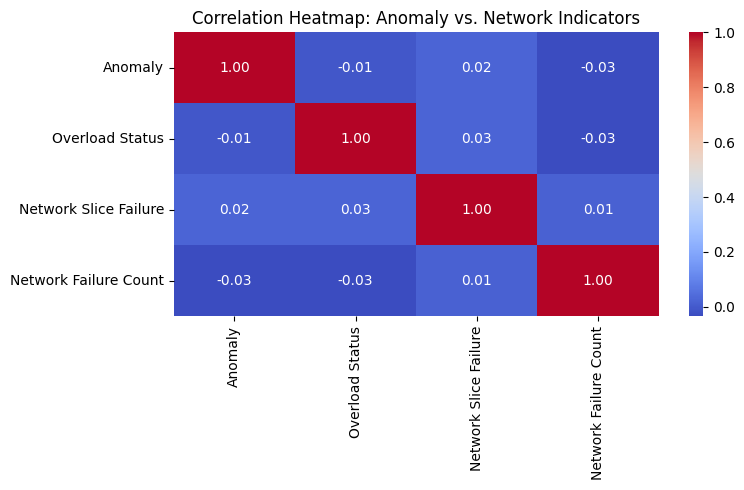

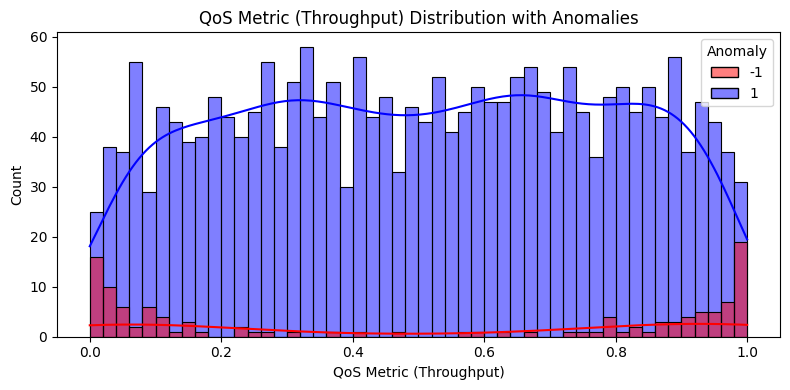

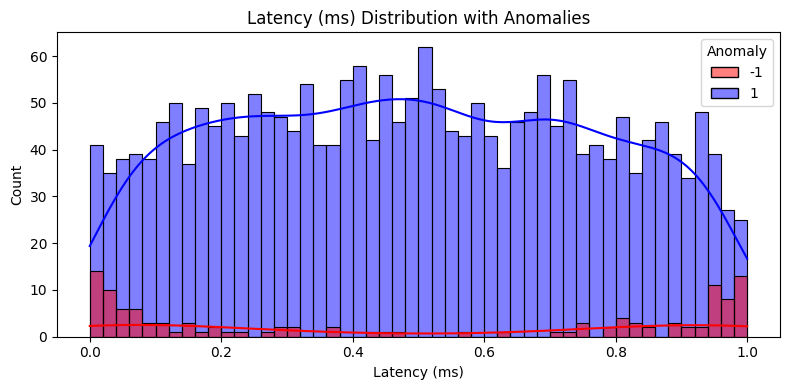

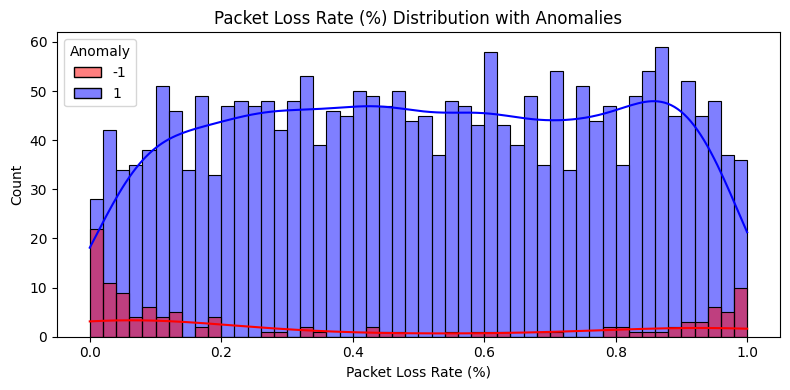

Anomalies detected: 118 out of 2345 (5.03%)


,Network Slice ID,Timestamp,Device ID,Traffic Load (bps),Traffic Type,Network Utilization (%),Latency (ms),Packet Loss Rate (%),Signal Strength (dBm),Bandwidth Utilization (%),Network Slice Failure,QoS Metric (Throughput),Overload Status,Device Type,Region,Network Failure Count,Time of Day,Weather Conditions,Anomaly
11,3,2025-01-01 11:00:00,195,0.351184,3,0.742708,0.113497,0.000083,0.776768,0.989278,1,0.737063,1,2,1,4,1,0,-1
19,3,2025-01-01 19:00:00,192,0.878874,2,0.057195,0.367645,0.938765,0.982842,0.852951,1,0.969866,1,0,3,4,2,1,-1
31,1,2025-01-02 07:00:00,116,0.623192,2,0.661618,0.001233,0.999832,0.930999,0.381020,0,0.622741,0,0,2,0,0,2,-1
44,4,2025-01-02 20:00:00,198,0.350956,0,0.386111,0.991593,0.938883,0.765714,0.879308,1,0.152064,1,0,0,3,2,2,-1
45,4,2025-01-02 21:00:00,151,0.755124,2,0.967220,0.209655,0.053767,0.764613,0.779206,1,0.944637,0,0,0,0,0,2,-1


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Load the dataset
df = pd.read_csv("5G_network_slicing_qos_dataset.csv")

# Select QoS-related features
qos_cols = ['QoS Metric (Throughput)', 'Latency (ms)', 'Packet Loss Rate (%)']
df_qos = df[qos_cols].copy()

# Scale the features
scaler = StandardScaler()
qos_scaled = scaler.fit_transform(df_qos)

# Detect anomalies using Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(qos_scaled)

# Correlation heatmap between anomaly label and failure-related indicators
plt.figure(figsize=(8, 5))
sns.heatmap(
    df[['Anomaly', 'Overload Status', 'Network Slice Failure', 'Network Failure Count']].corr(),
    annot=True, cmap='coolwarm', fmt=".2f"
)
plt.title("Correlation Heatmap: Anomaly vs. Network Indicators")
plt.tight_layout()
plt.show()

# Plot QoS distributions with anomaly labels
for col in qos_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, hue='Anomaly', bins=50, palette={1: 'blue', -1: 'red'}, kde=True)
    plt.title(f"{col} Distribution with Anomalies")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Extract anomalous rows for further analysis
anomalies_df = df[df['Anomaly'] == -1]
print(f"Anomalies detected: {len(anomalies_df)} out of {len(df)} ({len(anomalies_df)/len(df)*100:.2f}%)")
anomalies_df.head()

In [4]:
for col in df.columns:
    unique_vals = df[col].nunique()
    dtype = str(df[col].dtype)  # convert dtype to string
    print(f"{col:30} | Type: {dtype:<10} | Unique values: {unique_vals}")

Network Slice ID               | Type: int64      | Unique values: 4
Timestamp                      | Type: object     | Unique values: 2345
Device ID                      | Type: int64      | Unique values: 100
Traffic Load (bps)             | Type: float64    | Unique values: 2343
Traffic Type                   | Type: int64      | Unique values: 4
Network Utilization (%)        | Type: float64    | Unique values: 2345
Latency (ms)                   | Type: float64    | Unique values: 2345
Packet Loss Rate (%)           | Type: float64    | Unique values: 2345
Signal Strength (dBm)          | Type: float64    | Unique values: 2345
Bandwidth Utilization (%)      | Type: float64    | Unique values: 2345
Network Slice Failure          | Type: int64      | Unique values: 2
QoS Metric (Throughput)        | Type: float64    | Unique values: 2345
Overload Status                | Type: int64      | Unique values: 2
Device Type                    | Type: int64      | Unique values: 3
Region  

In [5]:
df['Anomaly'] = df_qos['Anomaly']  

# Frequency of anomalies by region
region_anomalies = df.groupby('Region')['Anomaly'].value_counts(normalize=True).unstack().fillna(0)

# By device type
device_anomalies = df.groupby('Device Type')['Anomaly'].value_counts(normalize=True).unstack().fillna(0)

# By time of day
time_anomalies = df.groupby('Time of Day')['Anomaly'].value_counts(normalize=True).unstack().fillna(0)

region_anomalies, device_anomalies, time_anomalies

(Anomaly        -1         1
 Region                     
 0        0.039568  0.960432
 1        0.065421  0.934579
 2        0.050093  0.949907
 3        0.044408  0.955592,
 Anomaly            -1         1
 Device Type                    
 0            0.055624  0.944376
 1            0.042857  0.957143
 2            0.052219  0.947781,
 Anomaly            -1         1
 Time of Day                    
 0            0.053571  0.946429
 1            0.037879  0.962121
 2            0.059818  0.940182)

In [6]:
correlation = df[['Anomaly', 'Overload Status', 'Network Slice Failure', 'Network Failure Count']].corr()
print(correlation)

                        Anomaly  Overload Status  Network Slice Failure  \
Anomaly                1.000000        -0.007534               0.022389   
Overload Status       -0.007534         1.000000               0.025638   
Network Slice Failure  0.022389         0.025638               1.000000   
Network Failure Count -0.034315        -0.030289               0.014743   

                       Network Failure Count  
Anomaly                            -0.034315  
Overload Status                    -0.030289  
Network Slice Failure               0.014743  
Network Failure Count               1.000000  
